# Classification in Machine Learning

© 2026 Yvan Richard.      
*All rights reserved*

## Foreword

In the previous chapter we discusses *linear regression*, a model used to predict a continuous real valued variable $y$. However, in many machine learning tasks we desire to predict discrete outcomes, classes such as : `['dog', 'cat']`. These *qualitative* variables are often referred to as *categorical* variables. In this notebook, we closelly follow the steps of Hastie et al. (2009) to understand what classification is and how machine learning can help us tackle those tasks.

In [128]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 

## Table of Contents

1. <a href="#part1">Overview & Dataset</a>
2. <a href="#part2">Logistic Regression</a>
3. <a href="#part3">Mutlinomial Classification with the Softmax</a>

## <a id = "part1" style = "color: inherit; ">1. Overview & Dataset</a>

### 1.1. The Classification Settings

The classification is a particular task of supervised learning, and just as in the regression settings, we have a set of predictors $X = \{x_1, x_2, \ldots, x_k\}$ that are leveraged to predict a discrete class $y$ (e.g. `'dog'`, or `'cat'`). With these data, we train different *classifiers* and test them on (unseen) test data to observe the performances of the model. Basically, those classifiers will estimate the following conditional probability: 

$$
P(Y = y^{(i)} \mid X = \{x_1^{(i)}, x_2^{(i)}, \ldots, x_k^{(i)} \})
$$

What is the probability of observing the particular class $y^{(i)}$ knowing the values of each $k$ predictor for this particular observation $x_k^{(i)}$. 
Evidently, the metrics with which we evaluate the classification are different than the regression and will be presented more in depth in later notebooks. Alongside this notebook, I will rely use a landmark dataset in machine learning for classification tasks: the `Iris` dataset.

### 1.2. A Landmark Dataset in Classification: `Iris`

#### Data Description

The `Iris` dataset is a canonical benchmark for supervised classification, originally collected by Fisher (1936) and still widely used to illustrate core concepts in statistical learning and machine learning. It contains 150 observations of iris flowers drawn from three species (Iris setosa, I. versicolor, and I. virginica), with each observation described by four continuous morphological measurements: sepal length, sepal width, petal length, and petal width. The task is a three-class classification problem in which the species label serves as the target variable. Owing to its low dimensionality, moderate class balance (50 instances per class), and absence of missing values, the dataset provides a clean environment for studying classifiers in controlled settings. Below is the schema of an iris:

<div align = "center">
    <img src = "images/iris-diagram-1.png" width="20%">
</div>

#### Loading the Dataset

Finally, I load the data set again by using the UC Irvine Machine Learning Repository:


In [129]:
# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 
  
# bind data and targets 
df = pd.concat([X, y], axis=1)

# display first 5 rows
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


We can also inspect the dimensionality of the data set (verify consistency with data description):

In [130]:
# dimensions of the dataset
print("Dataset dimensions:", df.shape)

# value counts of target variable
print("\nSpecies distribution\n", df['class'].value_counts())

Dataset dimensions: (150, 5)

Species distribution
 class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


#### Minimalistic Visualizations

To grasp how the data behave, I realize some visualizations. This section is not a comprehensive EDA of the dataset but merely an exploration of a few patterns in the data.

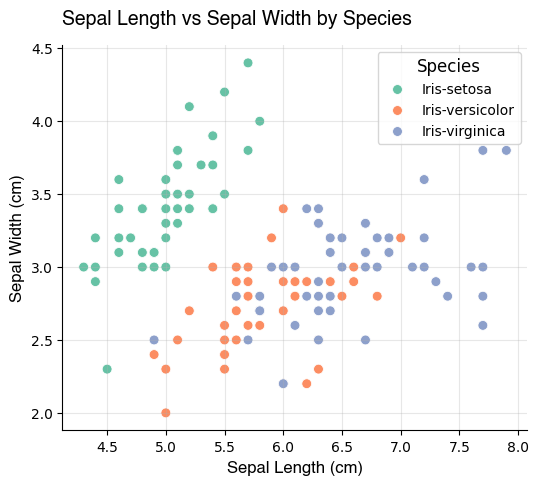

In [131]:
# scatter plot of sepal length vs sepal width colored by species
fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(data=df, x='sepal length', y='sepal width',
                hue='class', palette='Set2', s=50, ax=ax)

# aesthetics
ax.set_xlabel('Sepal Length (cm)', fontsize=12, family='Helvetica')
ax.set_ylabel('Sepal Width (cm)', fontsize=12, family='Helvetica')
ax.set_title('Sepal Length vs Sepal Width by Species', fontsize=14,
             family='Helvetica', loc='left', pad = 15)
ax.legend(title='Species', title_fontsize=12, fontsize=10, loc='upper right')
sns.despine()
ax.grid(alpha=0.3)
plt.show()

**Linear Separability**

For instance, in this plot it is really interesting to see that apparently, `Iris-setosa` is *linearily* separable from the two other species in this particular $x, y$ plan. Two classes (e.g. `'setosa'` and `'not setosa'`) are said to be linearily separable if there exists a linear decision boundary (a hyperplane) that separates them perfectly—i.e., all points of one class lie on one side and all points of the other class lie on the other side. (In machine learning the *perfectly* rarely applies but we approach it). However, if we use another $x, y$ plane, we might obtain linear separability for every class:

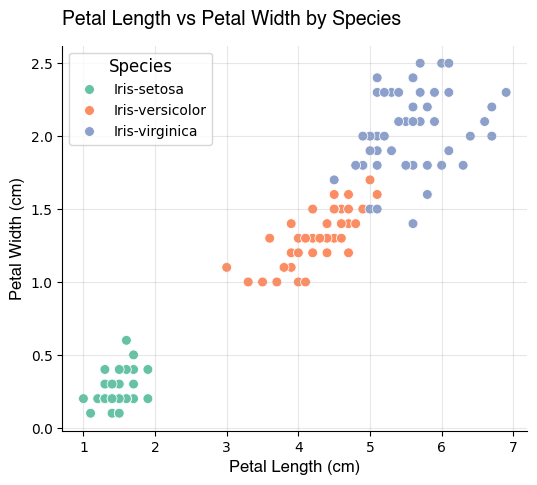

In [132]:
# scatter plot of sepal length vs sepal width colored by species
fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(data=df, x='petal length', y='petal width',
                hue='class', palette='Set2', s=50, ax=ax)

# aesthetics
ax.set_xlabel('Petal Length (cm)', fontsize=12, family='Helvetica')
ax.set_ylabel('Petal Width (cm)', fontsize=12, family='Helvetica')
ax.set_title('Petal Length vs Petal Width by Species', fontsize=14,
             family='Helvetica', loc='left', pad = 15)
ax.legend(title='Species', title_fontsize=12, fontsize=10, loc='upper left')
sns.despine()
ax.grid(alpha=0.3)
plt.show()

This dataset is especially nice for this reason, it is very evident to make some patterns emerge in the data, and we feel like we could almost hard-code some rules for classifying the species. However, this will poorly generalize to the real-world. In the next section, we therefore learn about the $101$ classifier algorithm: *logistic regression*. To use those data down the line, I already perform a train test split:

In [133]:
# train test split
from sklearn.model_selection import train_test_split

# shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['class']), df['class'], test_size=0.3, random_state=42,
    stratify=df['class']
)

# compute class priors
class_priors = y_train.value_counts(normalize=True)
print("Class Priors:\n", class_priors)

# compute class counts for training set
class_counts = y_train.value_counts()
print("\nClass Counts in Training Set:\n", class_counts)

# compute class counts for test set
test_class_counts = y_test.value_counts()
print("\nClass Counts in Test Set:\n", test_class_counts)

Class Priors:
 class
Iris-versicolor    0.333333
Iris-setosa        0.333333
Iris-virginica     0.333333
Name: proportion, dtype: float64

Class Counts in Training Set:
 class
Iris-versicolor    35
Iris-setosa        35
Iris-virginica     35
Name: count, dtype: int64

Class Counts in Test Set:
 class
Iris-virginica     15
Iris-versicolor    15
Iris-setosa        15
Name: count, dtype: int64


## <a id = "part2" style = "color: inherit; ">2. Logistic Regression</a>

### 2.1. Specifying the Model

As a classifier, the logistic regression needs to provide a way to estimate this conditional probability:

$$
P(Y = y^{(i)} \mid X = \{x_1^{(i)}, x_2^{(i)}, \ldots, x_k^{(i)} \}) = p(X)
$$

Once the probability has been computed, we simply need to specify a threshold $\delta$ (e.g. $\delta = 0.5$) for making predictions on the classes:

$$
\hat{y}^{(i)} = 
\begin{cases}
1 \quad \text{ if } \quad  \hat{p}(X^{(i)}) > \delta \\
0 \quad \text{ else } 
\end{cases}
$$

This is what we would predict for a *binary classification* task, where we only have to classes, e.g. `'setosa'` (1) and `'not setosa'` (0). This means that in order to make predictions, our estimated probabilities $\hat{p}(X^{(i)}) := \hat{p}^{(i)}$ needs to be between 0 and 1 (otherwise could not be treated as probabilities). However, in the second chapter of this repository, we saw that the multivariate linear regression is a weighted sum model that does not guarantee a mapping between 0 and 1. How can we solve this?

**The Sigmoid Function**

The logistic regression will aslo use a weighted sum model but then this weighted sum will be transformed by another function, in our case the sigmoid function $\sigma(z)$. The sigmoid function is defined as:

$$
\sigma : \mathbb{R} \rightarrow (0, 1), \quad \mid \quad \sigma(z) = \frac{1}{1 + e^{-z}} 
$$

We can code the sigmoid:

In [134]:
# sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

And plot the function:

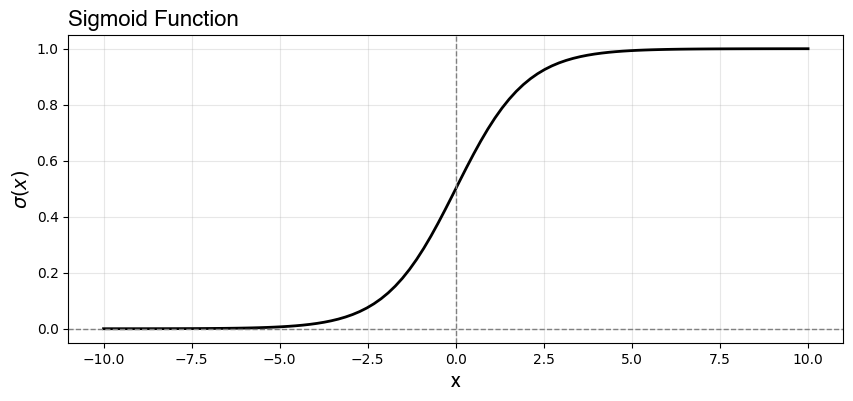

In [135]:
# data
x = np.linspace(-10, 10, 100)
y = sigmoid(x)

# plot
plt.figure(figsize=(10, 4))
plt.plot(x, y, color='black', lw=2)
plt.title('Sigmoid Function', fontsize=16, family='Helvetica', loc='left')
plt.xlabel('x', fontsize=14, family='Helvetica')
plt.ylabel(r'$\sigma(x)$', fontsize=14, family='Helvetica')
plt.grid(alpha=0.3)
plt.axhline(0, color='gray', lw=1, ls='--')
plt.axvline(0, color='gray', lw=1, ls='--')
plt.show()

Finally, the specification in binary classification is the following:

$$
\hat{p}^{(i)} = \sigma(X^{(i)}\hat\beta) \qquad \text{ probability for the positive class } 1.
$$

Once we have the probabilities, we simply do the mapping above with a given threshold $\delta$ to obtain the classes predictions.

### 2.2. Training the Logistic Regression

Once we established the model, we need to train the model, i.e. find the best $\hat\beta$ such as to minimize the classification errors. Now, which loss function for a classification task should we use? The classic standard in logistic regression is the so-called *log-loss*. To understand where it comes from, let us start with a classic framework.

#### The Maximum Likelihood Estimator (MLE)

The MLE is a well know statistical estimator and is closelly tied to the log-loss we will use. First, we have:

$$
p^{(i)} := P(y^{(i)} = 1 \mid X^{(i)}) = \sigma(X^{(i)} \beta).
$$

where $X^{(i)} (1 \times k)$ is defined by:

$$
X^{(i)} =
\begin{bmatrix}
1 & x_1^{(i)} & x_2^{(i)} & \ldots & x_k^{(i)} 
\end{bmatrix}
$$

and $\beta (k \times 1)$ by:

$$
\beta = 
\begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_k
\end{bmatrix}
$$

Now, if we which to capture not only $P(y^{(i)} = 1 \mid X^{(i)})$ but simply $P(y^{(i)} \mid X^{(i)})$, we can write:

$$
P(y^{(i)} \mid X^{(i)}) = p_{(i)}^{y^{(i)}} \cdot (1 - p_{(i)})^{1 - {y^{(i)}}}
$$

This is our Bernoulli probability mass function (pmf). You can check what happens when $y^{(i)} = 1$.
Now, for $n$ observations, we want to maximize the maximum likelihood function (MLF):

$$
\max_{\beta} : L(\beta) = \prod_{i = 1}^{n} p_{(i)}^{y^{(i)}} \cdot (1 - p_{(i)})^{1 - {y^{(i)}}}
$$

this is expressed in function of $\beta$ since $p_{(i)}$ depends on $\beta$. Then, if we take the log to remove the product $\prod$, we have:

$$
\max_{\beta} : \ell(\beta)=\log L(\beta)=\sum_{i=1}^n\Big[y^{(i)}\log p^{(i)}+(1-y^{(i)})\log(1-p^{(i)})\Big].
$$

And finally, it does not change anything if we take the average of $\ell(\beta)$ and minimize $-\ell(\beta)$ instead of maximizing it:

$$
\min_{\beta} : -\frac{1}{n} \sum_{i=1}^n\Big[y^{(i)}\log p^{(i)}+(1-y^{(i)})\log(1-p^{(i)})\Big] := J(\beta)
$$

and this is the loss function we will seek to optimize to find our optimal vector $\hat\beta$. However, here we cannot simply take the gradient and set it equal to $0$ since **no closed form solution exists**! To continue forward, we need to take a break from the logistic regression and focus on an algorithm called *gradient descent* (GD). However, it is still useful to note that the gradient of this function is:

$$
\nabla_{\beta} \; J(\beta) = \frac{1}{n} \sum_{i = 1}^{n} (\hat{p}^{(i)} - y^{(i)})X^{(i)}
$$

#### The Gradient Descent Algorithm (GD)

Once we have our gradient, we can use it to perform an algorithm named gradient descent. Gradient descent is an iterative algorithm that updates the parameters $\boldsymbol{\beta}$ in the direction of the negative gradient (to minimize the loss function). That is, we update the parameters by subtracting a scaled version of the gradient from the current parameters. The scaling factor is called the *learning rate*, $\eta$.

The algorithm is as follows:

1. Initialize the parameters $\boldsymbol{\beta}^{(0)}$ to some random values, initialize $t = 0$.
2. Compute the gradient of the loss function with respect to the parameters, $\nabla_{\boldsymbol{\beta}} J({\boldsymbol{\beta}^{(t)}})$.
3. Update the parameters by subtracting the learning rate times the gradient from the current parameters: 
$$\begin{align*}\boldsymbol{\beta}^{(t+1)} &\leftarrow \boldsymbol{\beta}^{(t)} - \eta \nabla_{\boldsymbol{\beta}} \hat{L}(f_{\boldsymbol{\beta}^{(t)}})\\
t &\leftarrow t + 1 \end{align*}$$
4. Repeat steps 2 and 3 until the parameters *converge*.

How do we know when the parameters converge? Remember that the gradient points in the direction of steepest ascent. Thus, if we keep updating the parameters in the direction of the negative gradient, we will eventually reach a local minimum of the loss function (exactly what we try to achieve). We can check if the parameters have converged by checking if the gradient is close to zero, which is equivalent to being in a *flat* region of the loss function.  That is, we can stop the algorithm when $\|\nabla_{\boldsymbol{\beta}} J({\boldsymbol{\beta}^{(0)}})\| < \epsilon$ for some small **convergence threshold** $\epsilon$ ($\|\mathbf{x}\|$ is the Euclidean norm). Let us first implement this algorithm:


In [136]:
# the log-loss gradient
def log_loss_gradient(X, y, beta):
    """
    Compute the gradient of the log-loss function.
    It is assumed that y is coded as 0 and 1.
    It is also assumed that X includes an intercept term (a column of ones).
    """
    n = len(y)
    predictions = sigmoid(X @ beta).reshape(-1, 1)
    gradient = (1/n) * (X.T @ (predictions - y))
    return gradient

# define a function to compute the estimates of the coefficients
# given a gradient function
def gradient_descent(X, y, gradient_func, learning_rate=0.01,
                     n_iterations=1000, threshold=1e-6):
    """Perform gradient descent to estimate coefficients."""

    # first, we determine the number of regressors
    n_features = X.shape[1]

    # initialize random coefficients
    np.random.seed(42)
    beta = np.random.randn(n_features).reshape(-1, 1)

    # algorithm
    for i in range(n_iterations):

        # compute the gradient
        nabla = gradient_func(X, y, beta)

        # update the parameters
        beta = beta - learning_rate * nabla

        # early stopping if the l2-norm is below threshold
        if np.linalg.norm(beta) <= threshold:
            print(f"GD converged after {i} steps.\n")
            break

    # return beta
    return beta

# classification function
def classify(X, beta, threshold=0.5):
    """Classify observations based on estimated coefficients and threshold."""
    probabilities = sigmoid(X @ beta)
    return (probabilities >= threshold).astype(int)

Now that we encoded the necessary function, we train the logistic regression model with the gradient descent algorithm. However, before doing so I indicate again that we are in a binary classification setting. We will therefore predict whether a particular observation $(i)$ is a setosa or not:

$$
y^{(i)} = 
\begin{cases}
1 : \quad \texttt{setosa} \\
0 : \quad \texttt{not setosa}
\end{cases}
$$

In [137]:
# final preparation of the training data
X_train_1 = np.hstack((np.ones((X_train.shape[0], 1)), X_train.values)).reshape(-1, X_train.shape[1]+1)
y_train_binary_1 = (y_train == 'Iris-setosa').astype(int).values.reshape(-1, 1)

# estimate coefficients
beta_hat_1 = gradient_descent(X_train_1, y_train_binary, log_loss_gradient,
                            learning_rate=0.1, n_iterations=10000)

# display estimated coefficients
print("Estimated coefficients:\n", beta_hat_1)

# prepare test data
X_test_1 = np.hstack((np.ones((X_test.shape[0], 1)), X_test.values)).reshape(-1, X_test.shape[1]+1)
y_test_binary_1 = (y_test == 'Iris-setosa').astype(int).values.reshape(-1, 1)
# make predictions
y_pred_1 = classify(X_test_1, beta_hat_1, threshold=0.5)

# compute accuracy
accuracy_1 = np.mean(y_pred_1 == y_test_binary_1)
print(f"\nTest Set Accuracy: {accuracy_1:.3f}")


Estimated coefficients:
 [[ 0.94395403]
 [ 0.17754291]
 [ 3.33252521]
 [-3.72158508]
 [-2.58727653]]

Test Set Accuracy: 1.000


As one can see, we obtained a perfect accuracy! This is a result we could have expected because we saw before that `setosa` is clearly almost perfectly linearily separable from the two other species. I must say however that in other ML projects, if you obtain such a high accuracy right away, it usually is a data leakage 😅. Still, if I try this with the following target variable:

$$
y^{(i)} = 
\begin{cases}
1 : \quad \texttt{virginica} \\
0 : \quad \texttt{not virginica}
\end{cases}
$$

we obtain a really high accuracy:

In [138]:
# preparation of the training data with virginica
y_train_binary_2 = (y_train == 'Iris-virginica').astype(int).values.reshape(-1, 1)

# estimate coefficients
beta_hat_2 = gradient_descent(X_train_1, y_train_binary_2, log_loss_gradient,
                            learning_rate=0.1, n_iterations=10000)

# display estimated coefficients
print("Estimated coefficients:\n", beta_hat_2)
# prepare test data
y_test_binary_2 = (y_test == 'Iris-virginica').astype(int).values.reshape(-1, 1)

# make predictions
y_pred_2 = classify(X_test_1, beta_hat_2, threshold=0.5)
# compute accuracy
accuracy_2 = np.mean(y_pred_2 == y_test_binary_2)
print(f"\nTest Set Accuracy: {accuracy_2:.3f}")

Estimated coefficients:
 [[-3.62698521]
 [-3.84682025]
 [-3.60617195]
 [ 5.1285475 ]
 [ 7.55909093]]

Test Set Accuracy: 0.978


We can also try to play around with the decision threshold $\delta$:

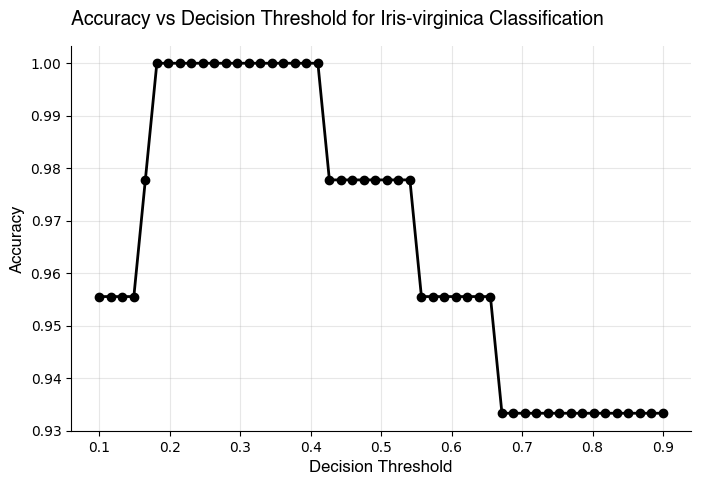

In [139]:
# different decision thresholds
deltas = np.linspace(0.1, 0.9, 50)
accuracies = []

for delta in deltas:
    y_pred_delta = classify(X_test_1, beta_hat_2, threshold=delta)
    acc = np.mean(y_pred_delta == y_test_binary_2)
    accuracies.append(acc)

# plot accuracy vs. decision threshold
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(deltas, accuracies, marker='o', color='black', lw=2)
ax.set_xlabel('Decision Threshold', fontsize=12, family='Helvetica')
ax.set_ylabel('Accuracy', fontsize=12, family='Helvetica')
ax.set_title('Accuracy vs Decision Threshold for Iris-virginica Classification', fontsize=14,
             family='Helvetica', loc='left', pad = 15)
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

*Note: the fact that the function is not smooth is because we have very few data in the test set. Hence, when we adjust slightly the decision boundary only a few observations can shift the accuracy drastically.*

#### Training with Mini-batch Gradient Descent

In full-batch gradient descent, the parameter update at iteration $t$ is computed using the gradient of the empirical risk evaluated on the entire training set (in our case this is fine since we only have 105 observations). While this is feasible for small samples, it becomes computationally inefficient as $n$ grows, because each update requires a complete pass through the data. Mini-batch gradient descent addresses this scalability issue by replacing the full gradient with a gradient computed on a small randomly sampled subset (a *mini-batch*) of observations. Beyond efficiency, this controlled randomness can also improve optimization behaviour by reducing the tendency of deterministic updates to linger in flat regions or near saddle points.

Let the training set be:

$$
\{(X^{(i)},y^{(i)})\}_{i=1}^n
$$

 and consider an objective of the form:

$$
J(\beta)=\frac{1}{n}\sum_{i=1}^n \ell\!\left(f(X^{(i)};\beta),y^{(i)})\right)
$$,

where $\ell(\cdot)$ is a per-observation loss and $f(\cdot;\beta)$ is the model. At iteration $t$, mini-batch gradient descent samples a subset $B_t \subset \{1,\dots,n\}$ with $|B_t|=m$ and forms the mini-batch objective
$J_{B_t}(\beta)=\frac{1}{m}\sum_{i\in B_t}\ell\!\left(f(x_i;\beta),y_i\right)$.
The corresponding gradient estimate is $g_t=\nabla J_{B_t}(\beta_t)$, and the parameters are updated according to
$\beta_{t+1}=\beta_t-\eta_t\, g_t$,
where $\eta_t>0$ denotes the learning rate.

A central justification for mini-batching is that, under uniform random sampling, $g_t$ is an unbiased estimator of the full gradient. Formally,
$\mathbb{E}[g_t \mid \beta_t]=\nabla J(\beta_t)$.
Thus, mini-batch gradient descent preserves the *direction* of steepest descent in expectation, while reducing the cost per update from $O(n)$ to $O(m)$ with $m\ll n$. In practice, this enables more frequent updates for a fixed computational budget and makes training viable for large datasets.

Mini-batching also introduces stochasticity into the optimization path. Unlike full-batch updates, which follow a deterministic trajectory, mini-batch updates fluctuate around the true gradient due to sampling noise. This noise can be beneficial: in high-dimensional non-convex objectives, the loss surface often contains flat plateaus and saddle points where gradients are small. Random perturbations help the iterates move away from such regions rather than progressing slowly along near-zero gradients. Empirically, this often leads to faster progress early in training and can improve the quality of the solution found by the optimizer.

Finally, mini-batch methods provide a pragmatic compromise between full-batch gradient descent and purely stochastic gradient descent (which uses $m=1$). Compared to $m=1$, moderate batch sizes reduce gradient variance and exploit efficient vectorized computation (e.g., matrix operations on modern hardware). Compared to full-batch updates, they remain computationally scalable while retaining enough randomness to improve exploration of the objective landscape.

For a vizual explanation in under 3 minutes, I recommend this [video](https://www.youtube.com/watch?v=UmathvAKj80). Furthermore, the reader should note that many many other gradient descent methods exist. One of the current landmark is presented by Duchi et al. (2011) in their paper *Adaptive subgradient methods for online learning and stochastic optimization*. Their algorithm is called `AdaGrad` and it has a brillant idea:

> AdaGrad adapts the learning rate per parameter by scaling updates with the inverse square root of the cumulative sum of past squared gradients. Parameters that receive frequent large gradients get smaller steps; infrequent ones get larger steps.

In the section below, I demonstrate how mini-batch GD works. Furthermore, note that $\eta$ is updated according to the following learning schedule:

$$
\eta_t = \frac{\eta_0}{\sqrt{t}}
$$

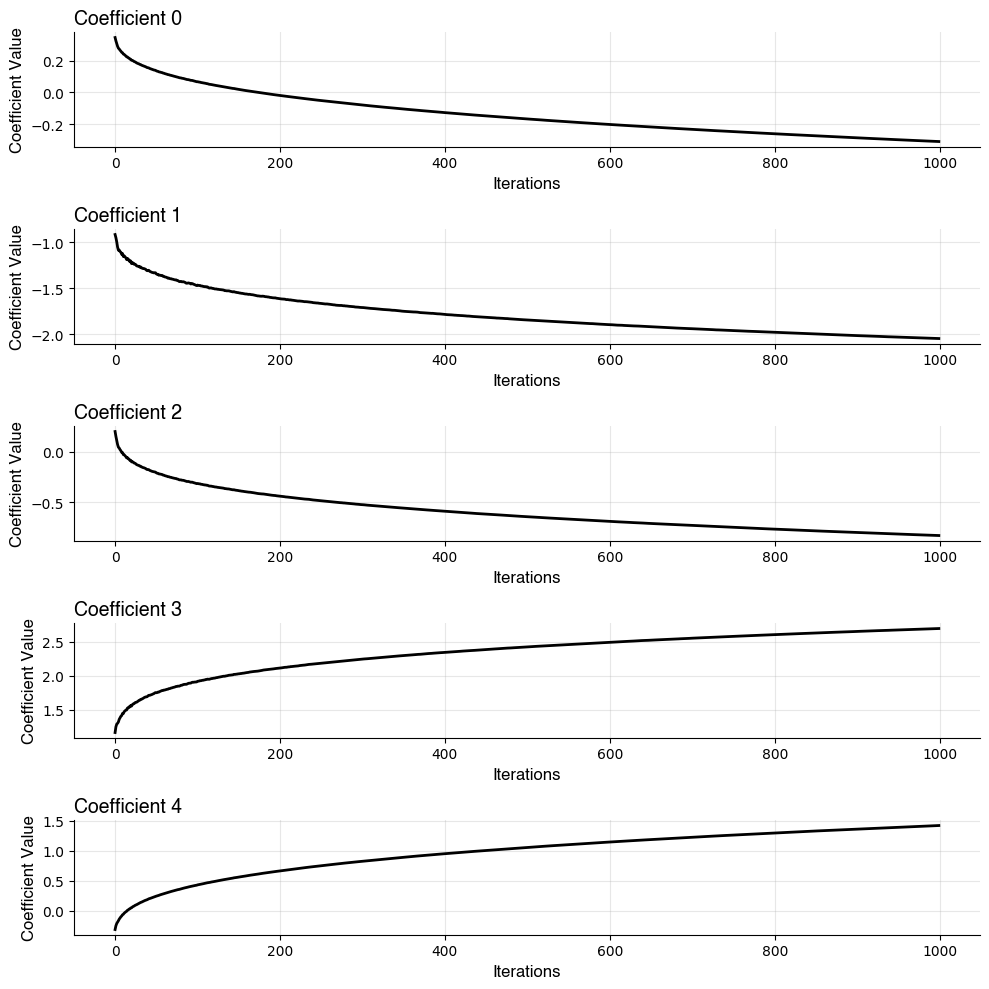


Test Set Accuracy (Mini-Batch GD): 1.000


In [140]:
# mini batch gradient descent

# configure parameters
np.random.seed(42)
beta_hat = np.random.randn(X_train_1.shape[1]).reshape(-1, 1) # random initialization
n_iterations = 1000 # number of epochs
batch_size = 15 # number of observations per mini batch
eta_0 = 0.1 # initial learning rate
eta = eta_0

# store coefficient values
betas = []


# the algorithm
for i in range(n_iterations):

    # shuffle the data at each epoch
    indices = np.random.permutation(X_train_1.shape[0])
    X_shuffled = X_train_1[indices]
    y_shuffled = y_train_binary_2[indices]

    # iterate over mini batches (without replacement)
    for start_idx in range(0, X_train_1.shape[0], batch_size):
        end_idx = start_idx + batch_size
        X_batch = X_shuffled[start_idx:end_idx]
        y_batch = y_shuffled[start_idx:end_idx]

        # compute the gradient on the mini batch
        nabla = log_loss_gradient(X_batch, y_batch, beta_hat)

        # update the parameters
        beta_hat = beta_hat - eta * nabla 

    # store the coefficients
    betas.append(beta_hat.flatten())

    # update the learning rate
    eta = eta_0 / np.sqrt(i + 1)
    

# plot the evolution of coefficients
betas = np.array(betas)
fig, ax = plt.subplots(betas.shape[1], 1, figsize=(10, 10))
for i in range(betas.shape[1]):
    ax[i].plot(betas[:, i], color='black', lw=2)
    ax[i].set_title(f'Coefficient {i}', fontsize=14, family='Helvetica', loc ='left')
    ax[i].set_xlabel('Iterations', fontsize=12, family='Helvetica')
    ax[i].set_ylabel('Coefficient Value', fontsize=12, family='Helvetica')
    ax[i].grid(alpha=0.3)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# make predictions
y_pred_mb = classify(X_test_1, beta_hat, threshold=0.5)

# compute accuracy
accuracy_mb = np.mean(y_pred_mb == y_test_binary_2)
print(f"\nTest Set Accuracy (Mini-Batch GD): {accuracy_mb:.3f}")

This time, we even obtained better results. In the next section, I introduce what the softmax regression is and why we use it for **multinomial classification** (that is, when we have more than one class).

### <a id = "part3" style = "color: inherit;">2.3. Mutlinomial Classification with the Softmax</a>

This section is inspired by Aurélien Géron's book *Hands-on Machine Learning*.

This classification regression can serve for multiclass classification. The idea behind softmax regression is intutitive. You first compute a score $s_k(x)$ for a given instance $x$ and each class $k$, then you estimate the probabilities (based on the score) that a certain instance belong to a given class. Then, you will predict the class with the higher probability. 

We compute the score with: 
$$
s_k(x) = (\beta^{(k)})^T x 
$$

Important to note that each class $k$ has its own parameter vector $\theta_k$. Usually, all these vectors are stored in the so-called *parameter matrix* $\Beta$ (neural network are not so far away). Once we have computed the whole $\Beta$, we can estimate the probabilities $p_k$ for each class with the softmax function: 
$$
\hat{p}_k = \sigma(s(x))_k = \frac{e^{s_k(x)}}{\sum_{j=1}^{K} e^{s_j(x)}}
$$
In this equation: 
+ $K$ is the number of classes 
+ $s(x)$ is a vector contaning the scores of each class for the instance $x$
+ $\sigma(s(x))_k$ is the probability that the instance $x$ belongs to class $k$, given the scores of each class for that instance.

🔴 The softmax regression is a multiclass regression but not a multioutput (i.e. it will only output one class). This means that it should only be used with mutually exclusive classes!

**How Training Happens?**

During training, we use a popular loss function in machine learning called **cross-entropy**: 
$$
J(\Beta) = - \frac{1}{n} \sum_{i=1}^{n} \sum_{k=1}^{K} y_k^{(i)} \text{log}(\hat{p}_k^{(i)})
$$

Where $y_k^{(i)}$ is the target probability that the instance $x_i$ belongs to the class $k$. In general we choose either $0$ or $1$ (where 1 means it belongs to class $k$ of course).

**How do we Obtain the Cross-Entropy Loss Function?**

To estimate the model parameters  $\Beta$ , we maximize the likelihood of observing the training data.
The probability of the dataset under our model is given by the likelihood function:


$$L(\Beta) = \prod_{i=1}^{n} P(y^{(i)} \mid x^{(i)}; \Beta)$$


Since our model predicts probabilities  $\hat{p}_k^{(i)}$  and the labels are one-hot encoded, the likelihood function can be rewritten as:


$$L(\Beta) = \prod_{i=1}^{n} \prod_{k=1}^{K} (\hat{p}_k^{(i)})^{y_k^{(i)}}$$


where only the term corresponding to the true class survives (since  $y_k^{(i)} = 1$  for the correct class and  $0$  otherwise).
Since it is easier to work with sums instead of products, we take the log-likelihood:

$$\log L(\Beta) = \sum_{i=1}^{n} \sum_{k=1}^{K} y_k^{(i)} \log \hat{p}_k^{(i)}$$

MLE involves maximizing this log-likelihood. However, in machine learning, we typically minimize a loss function instead of maximizing a likelihood. To achieve this, we define the loss function as the negative log-likelihood:

$$J(\Beta) = - \frac{1}{n} \sum_{i=1}^{n} \sum_{k=1}^{K} y_k^{(i)} \log \hat{p}_k^{(i)}$$

which is exactly the **cross-entropy loss**.

**After the Loss Function, the Gradient**  

Once we have computed the cross-entropy loss function, we should take the gradient of $J(\Beta)$ with regard to $\beta^{(k)}$. As for the logistic regression gradient, this takes some work but here we display, this time, just the result: 
$$
\nabla_{\beta^{(k)}} J(\Beta) = \frac{1}{n} \sum_{i=1}^{n} (\hat{p}_k^{(¡)} - y_k^{(i)})x^{(i)}
$$



In [143]:
# softmax function
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # for numerical stability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# gradient descent for softmax regression
def softmax_loss_gradient(X, y_onehot, beta):
    """
    Compute the gradient of the softmax loss function.
    It is assumed that y_onehot is one-hot encoded.
    It is also assumed that X includes an intercept term (a column of ones).
    """
    n = len(y_onehot)
    scores = X @ beta
    probabilities = softmax(scores)
    gradient = (1/n) * (X.T @ (probabilities - y_onehot))
    return gradient

# one-hot encode the target variable
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.values.reshape(-1, 1))

# estimate coefficients using gradient descent
beta_hat_softmax = gradient_descent(X_train_1, y_train_onehot, softmax_loss_gradient,
                                   learning_rate=0.1, n_iterations=10000)

# display estimated coefficients
print("Estimated coefficients (Softmax Regression):\n", beta_hat_softmax)

# make predictions
scores_test = X_test_1 @ beta_hat_softmax
probabilities_test = softmax(scores_test)
y_pred_softmax = np.argmax(probabilities_test, axis=1)

print(y_pred_softmax[:10])  # display first 10 predictions

# compute accuracy
accuracy_softmax = np.mean(y_pred_softmax == y_test.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}).values)
print(f"\nTest Set Accuracy (Softmax Regression): {accuracy_softmax:.3f}")

Estimated coefficients (Softmax Regression):
 [[ 1.16078393  3.00793489 -2.87857635]
 [ 1.08476873  0.39013988 -3.06017771]
 [ 4.10485194  0.50061505 -3.27211566]
 [-3.60167317  1.33783262  6.07959678]
 [-2.74681402 -3.52120875  5.32422931]]
[2 1 2 1 2 2 1 1 0 1]

Test Set Accuracy (Softmax Regression): 0.978


### Conclusion

In this notebook, we learned what a classification task is and uncovered two famous classifiers; the logistic regression and the softmax regression. We also introduce the gradient descent algorithm! In later notebooks, I will present the classification metrics used to discuss the performances of a classifier, as well as other possible classifier, such as decision trees, random forests, or neural networks.

## References

- Duchi, J., Hazan, E., & Singer, Y. (2011). Adaptive subgradient methods for online learning and stochastic optimization. *Journal of machine learning research*, 12(7).
- Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. *Annals of eugenics*, 7(2), 179-188.
- Géron, A. (2022). *Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow*. " O'Reilly Media, Inc.".
- Hastie, T., Tibshirani, R., & Friedman, J. (2009). *An introduction to statistical learning*.
